This file is going to demonsatrate how to use Ordianry Least Square Regression, Ridge Regression and FRDM models to predict the mass of nuclei. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

We need to define some basic functions 

In [2]:
def cal_mse(A, Y, beta):
    y_hat = A.dot(beta)
    mse = np.square(y_hat-Y).mean()
    return mse

def cal_beta(A, Y):
    beta = (np.linalg.pinv((A.T).dot(A)).dot(A.T)).dot(Y)
    return beta

def cal_beta_r(A, Y):
    beta = (np.linalg.pinv((A.T).dot(A)+0.01*np.identity(8)).dot(A.T)).dot(Y)
    return beta

def std_data(X):
    X_std = stats.zscore(X, axis = 0)
    b = np.ones((len(X),1))
    X_new = np.concatenate((b,X_std), axis = 1)
    return X_new

def cal_pair(Z, N):
    Z, N = np.atleast_1d(Z), np.atleast_1d(N)
    A = Z+N
    sgn = np.zeros(len(Z))
    for i in range(len(Z)):
        if (Z[i]%2==0) and (N[i]%2==0):
            sgn[i] = 1
        if (Z[i]%2==1) and (N[i]%2==1):
            sgn[i] = -1
    return A, sgn

def get_exp(ele, Z, N, ME):
    IND = [index for index, element in enumerate(Z) if element == ele]
    N_ele = [N[i] for i in iter(IND)]
    ME_ele = [ME[i]*10**(-3) for i in iter(IND)] #Mass Excess of Fe in MeV 
    return N_ele, ME_ele

def SEMF(Z, N):
    aV, aS, aC, aA, delta = 15.75, 17.8, 0.711, 23.7, 11.18
    Z, N = np.atleast_1d(Z), np.atleast_1d(N)
    # Total number of nucleons
    A = Z+ N
    sgn = np.zeros(len(Z))
    for i in range(len(Z)):
        if (Z[i]%2==0) and (N[i]%2==0):
            sgn[i] = 1
        if (Z[i]%2==1) and (N[i]%2==1):
            sgn[i] = -1
    
    # The SEMF for the average binding energy per nucleon.
    E = (aV - aS / A**(1/3) - aC * Z**2 / A**(4/3) -
         aA * (A-2*Z)**2/A**2 + sgn * delta/A**(3/2))
    if Z.shape[0] == 1:
        return float(E)
    return E 

First, we need to get the experimental data from a txt file.

In [3]:
data = [line.strip('\n') for line in open('mass16.txt')][39:]
sep_n = [6,8]
sep_z = [11,13]
sep_me = [29,40]
sep_mass = [96, 112]

N = [int(line[sep_n[0]:sep_n[1]+1]) for line in data]
Z = [int(line[sep_z[0]:sep_z[1]+1]) for line in data]
ME = np.array([float(line[sep_me[0]:sep_me[1]+1].replace('#', '')) for line in data]) # in kev
MN = np.array([float(line[sep_mass[0]:sep_mass[1]+1].replace(' ','').replace('#', '')) for line in data])
MN = MN*10**(-6) #mass number in u
unit = 931.505 #convert u to MeV/c^2
MASS = MN*unit
mn = MASS[0]
mp = MASS[1]
A, sgn = cal_pair(Z, N) 
Mass_excess = (MN - A) * unit



Then, we select an element that we would like to explore.

In [4]:
ele = 71

Plot experimental data of specific element

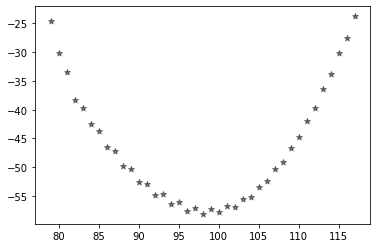

In [5]:
N_exp, ME_exp = get_exp(ele, Z, N, ME)
plt.scatter(N_exp, ME_exp, marker = '*', alpha = 0.5, label = 'AME2016', color = 'black', zorder=5) 

Get the training data and test data

In [6]:
def create_test(ele, num, Z, N, Nt, MASS):
    Z_test = ele*np.ones(num+1)
    N_test = [N_exp[-1]+i+1 for i in range(num+1)]
    Z = np.concatenate((Z, Z_test), axis=0)
    N = np.concatenate((N, N_test), axis=0)
    A, sgn = cal_pair(Z, N) 
    X = np.array([Z, N, A, A*A**(-1/3), A*Z**2/A**(4/3), (A-2*Z)**2/A,  A * sgn / A**(3/2)]).T
    x = std_data(X)
    x_train = x[:Nt, :]
    x_test = x[Nt:,:]
    y_train = MASS[:Nt]
    return Z, N, A, x_train, x_test, y_train

Z, N, A, x_train, x_test, y_train = create_test(ele, 5, Z, N, 3200, MASS)    

If we choose to use the OLS regression, the beta will be this vanilla form. 

In [7]:
beta = cal_beta(x_train,y_train)

def plot_pre(beta, ele, Z, N, A, x_train, x_test, y_train):
    y_hat_train = x_train.dot(beta)
    y_hat_test = x_test.dot(beta)
    Y = np.concatenate((y_hat_train, y_hat_test), axis=0)
    IND = [index for index, element in enumerate(Z) if element == ele]
    N_pre = [N[i] for i in iter(IND)]
    M_pre = [Y[i] for i in iter(IND)] #Mass Excess of Fe in MeV 
    ME_pre = M_pre - (ele+np.array(N_pre))*931.505 
    return N_pre, ME_pre

Plot the ordinary least square prediction

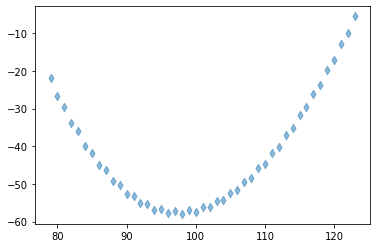

In [8]:
N_pre, ME_pre = plot_pre(beta, ele, Z, N, A, x_train, x_test, y_train)    
plt.scatter(N_pre, ME_pre, marker = 'd', alpha = 0.5, label = 'OLS Regression')

Plot redge regression prediction

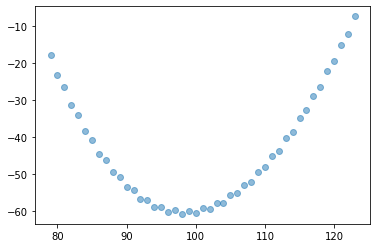

In [9]:
beta = cal_beta_r(x_train,y_train)
N_pre, ME_pre = plot_pre(beta, ele, Z, N, A, x_train, x_test, y_train)    
plt.scatter(N_pre, ME_pre, marker = 'o', alpha = 0.5, label = 'Ridge Regression')

Plot SEMF predictions

Text(115, -53.624972114979755, 'Lu')

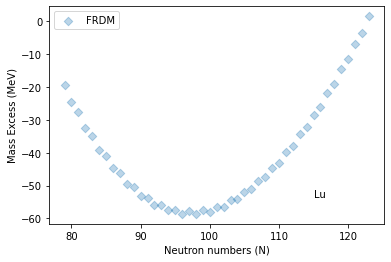

In [10]:
Mass_ex = []
IND = [index for index, element in enumerate(Z) if element == ele]
N_se = [N[i] for i in iter(IND)]

for i in range(len(N_se)):
    se_be = SEMF(ele, N_se[i])
    mass_ex = mn*N_se[i] + mp*ele - (N_se[i]+ele)*se_be - (N_se[i]+ele)*931.505
    Mass_ex.append(mass_ex)
    
plt.scatter(N_se, Mass_ex, marker = 'D', alpha = 0.3, label = 'FRDM')
plt.legend()
plt.xlabel('Neutron numbers (N)')
plt.ylabel('Mass Excess (MeV)')
#plt.title('Z = ' + str(ele))
#plt.ylim(-75, 0)
#plt.xlim(75, 125)
y = np.array(Mass_ex).min() + 5
x = np.array(N_se).max() - 8 
plt.text(x, y, 'Lu')